# Memory usage

The [first benchmark](http://www.xavierdupre.fr/app/_benchmarks/helpsphinx/sklbench_results/index.html) based on [scikti-learn's benchmark](https://github.com/jeremiedbb/scikit-learn_benchmarks) shows high peaks of memory usage for the python runtime on linear models. Let's see how to measure that.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Artificial huge data 

In [2]:
import numpy
N, nfeat = 300000, 200
N * nfeat * 8 / 1e9

0.48

In [3]:
X = numpy.random.random((N, nfeat))
y = numpy.empty((N, 50))
for i in range(y.shape[1]):
    y[:, i] = X.sum(axis=1) + numpy.random.random(N)
X.shape, y.shape

((300000, 200), (300000, 50))

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1)

In [5]:
from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [6]:
from mlprodict.onnx_conv import to_onnx
from mlprodict.onnxrt import OnnxInference
clr_onnx = to_onnx(clr, X_train[:1])
oinfpy = OnnxInference(clr_onnx, runtime='python')

Let's minimize the cost of verifications on scikit-learn's side.

In [7]:
from sklearn import set_config
set_config(assume_finite=True)

## Profiling the prediction function

In [8]:
from pyquickhelper.pycode.profiling import profile
print(profile(lambda: clr.predict(X_test), 
              pyinst_format='text')[1])


  _     ._   __/__   _ _  _  _ _/_   Recorded: 12:58:12  Samples:  3
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.383     CPU time: 0.547
/   _/                      v3.0.1

Program: c:\python372_x64\lib\site-packages\ipykernel_launcher.py -f C:\Users\xavie\AppData\Roaming\jupyter\runtime\kernel-e4d27f6f-be45-4c43-8a6f-ee189d21f0d0.json

0.383 profile  pyquickhelper\pycode\profiling.py:49
|- 0.370 <lambda>  <ipython-input-8-1097e70fe6c7>:2
|  `- 0.370 predict  sklearn\linear_model\base.py:208
|     `- 0.370 _decision_function  sklearn\linear_model\base.py:201
|        |- 0.222 safe_sparse_dot  sklearn\utils\extmath.py:118
|        `- 0.148 [self]  
`- 0.013 [self]  




In [9]:
import numpy

def nastype32(mat):
    return mat.astype(numpy.float32)

print(profile(lambda: oinfpy.run({'X': nastype32(X_test)}), 
              pyinst_format='text')[1])


  _     ._   __/__   _ _  _  _ _/_   Recorded: 12:58:13  Samples:  5
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.484     CPU time: 0.500
/   _/                      v3.0.1

Program: c:\python372_x64\lib\site-packages\ipykernel_launcher.py -f C:\Users\xavie\AppData\Roaming\jupyter\runtime\kernel-e4d27f6f-be45-4c43-8a6f-ee189d21f0d0.json

0.484 profile  pyquickhelper\pycode\profiling.py:49
|- 0.478 <lambda>  <ipython-input-9-da4aa05db7ed>:6
|  |- 0.301 nastype32  <ipython-input-9-da4aa05db7ed>:3
|  |- 0.145 run  mlprodict\onnxrt\onnx_inference.py:333
|  |  `- 0.145 _run_sequence_runtime  mlprodict\onnxrt\onnx_inference.py:412
|  |     `- 0.145 run  mlprodict\onnxrt\onnx_inference_node.py:116
|  |        `- 0.145 run  mlprodict\onnxrt\ops_cpu\_op.py:279
|  |           `- 0.145 run  mlprodict\onnxrt\ops_cpu\_op.py:199
|  |              `- 0.145 _run  mlprodict\onnxrt\ops_cpu\op_linear_regressor.py:27
|  |                 |- 0.126 numpy_dot_inplace  mlprodict\onnxrt\ops_cpu\_op_numpy_

Most of the time is taken out into casting into float. Let's take it out.

In [10]:
X_test32 = X_test.astype(numpy.float32)

print(profile(lambda: oinfpy.run({'X': X_test32}), 
              pyinst_format='text')[1])


  _     ._   __/__   _ _  _  _ _/_   Recorded: 12:58:14  Samples:  3
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.094     CPU time: 0.156
/   _/                      v3.0.1

Program: c:\python372_x64\lib\site-packages\ipykernel_launcher.py -f C:\Users\xavie\AppData\Roaming\jupyter\runtime\kernel-e4d27f6f-be45-4c43-8a6f-ee189d21f0d0.json

0.094 profile  pyquickhelper\pycode\profiling.py:49
|- 0.089 <lambda>  <ipython-input-10-fe055596e921>:3
|  `- 0.089 run  mlprodict\onnxrt\onnx_inference.py:333
|     `- 0.089 _run_sequence_runtime  mlprodict\onnxrt\onnx_inference.py:412
|        `- 0.089 run  mlprodict\onnxrt\onnx_inference_node.py:116
|           `- 0.089 run  mlprodict\onnxrt\ops_cpu\_op.py:279
|              `- 0.089 run  mlprodict\onnxrt\ops_cpu\_op.py:199
|                 `- 0.089 _run  mlprodict\onnxrt\ops_cpu\op_linear_regressor.py:27
|                    |- 0.079 numpy_dot_inplace  mlprodict\onnxrt\ops_cpu\_op_numpy_helper.py:8
|                    |  `- 0.079 dot  <__ar

Much better.

## SGDClasifier

This models is implemented with many ONNX nodes. Let's how it behaves.

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import load_iris
data = load_iris()
Xir, yir = data.data, data.target
Xir_train, Xir_test, yir_train, yir_test = train_test_split(Xir, yir)
sgcl = SGDClassifier()
sgcl.fit(Xir_train, yir_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
sgd_onnx = to_onnx(sgcl, Xir_train.astype(numpy.float32))

In [13]:
%load_ext mlprodict

In [14]:
%onnxview sgd_onnx

In [15]:
sgd_oinf = OnnxInference(sgd_onnx)

In [16]:
def call_n_times_x1(n, X_test, sgd_oinf):
    for i in range(n):
        res = sgd_oinf.run({'X': X_test})
    return res

call_n_times_x1(20, Xir_test[:1].astype(numpy.float32), sgd_oinf)

{'output_label': array([2], dtype=int64),
 'output_probability': [{0: -172.99298, 1: 219.83615, 2: 223.34476}]}

In [17]:
sgcl.decision_function(Xir_test[:1])

array([[-172.99297305,  219.83611031,  223.34468148]])

In [18]:
xir_32 = Xir_test[:1].astype(numpy.float32)

print(profile(lambda: call_n_times_x1(20000, xir_32, sgd_oinf), 
              pyinst_format='text')[1])


  _     ._   __/__   _ _  _  _ _/_   Recorded: 12:58:15  Samples:  1077
 /_//_/// /_\ / //_// / //_'/ //     Duration: 1.585     CPU time: 1.500
/   _/                      v3.0.1

Program: c:\python372_x64\lib\site-packages\ipykernel_launcher.py -f C:\Users\xavie\AppData\Roaming\jupyter\runtime\kernel-e4d27f6f-be45-4c43-8a6f-ee189d21f0d0.json

1.584 profile  pyquickhelper\pycode\profiling.py:49
`- 1.584 <lambda>  <ipython-input-18-ec5a6181dc40>:3
   `- 1.584 call_n_times_x1  <ipython-input-16-32f502ef162e>:1
      |- 1.545 run  mlprodict\onnxrt\onnx_inference.py:333
      |  |- 1.487 _run_sequence_runtime  mlprodict\onnxrt\onnx_inference.py:412
      |  |  |- 1.331 run  mlprodict\onnxrt\onnx_inference_node.py:116
      |  |  |  |- 0.515 [self]  
      |  |  |  |- 0.370 run  mlprodict\onnxrt\ops_cpu\_op.py:112
      |  |  |  |  |- 0.228 _run  mlprodict\onnxrt\ops_cpu\op_array_feature_extractor.py:17
      |  |  |  |  |- 0.056 _run  mlprodict\onnxrt\ops_cpu\op_cast.py:36
      |  |  | 

The code in ``mlprodict/onnxrt/onnx_inference_node.py`` just calls an operator and updates the list containing all the results. The time in here is significant if the number of node is huge if the python runtime is used.

## Memory profiling

In [19]:
%matplotlib inline

In [20]:
from memory_profiler import memory_usage
memprof_skl = memory_usage((clr.predict, (X_test, )), timestamps=True, interval=0.01)

In [21]:
memprof_skl

[(1548.078125, 1571828296.9566615),
 (1548.078125, 1571828299.8003368),
 (1556.70703125, 1571828299.8113093),
 (1565.3203125, 1571828299.8223698),
 (1572.63671875, 1571828299.8331084),
 (1581.921875, 1571828299.844079),
 (1587.1953125, 1571828299.8540835),
 (1594.5234375, 1571828299.865023),
 (1601.18359375, 1571828299.8759935),
 (1606.8984375, 1571828299.886965),
 (1615.3203125, 1571828299.897937),
 (1623.953125, 1571828299.9089084),
 (1633.41015625, 1571828299.9198797),
 (1641.4375, 1571828299.9304154),
 (1650.6953125, 1571828299.941384),
 (1666.09765625, 1571828299.9523551),
 (1680.58203125, 1571828299.9633253),
 (1695.90234375, 1571828299.9742956),
 (1710.421875, 1571828299.9852667),
 (1725.75390625, 1571828299.996237),
 (1738.515625, 1571828300.007209),
 (1753.70703125, 1571828300.0181797),
 (1660.453125, 1571828300.029152),
 (1651.078125, 1571828300.0306547)]

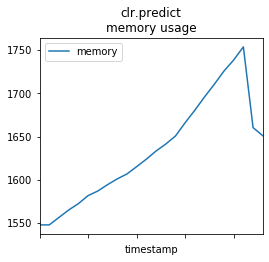

In [22]:
import matplotlib.pyplot as plt
from pandas import DataFrame, to_datetime

def mem_profile_plot(mem, title):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    df = DataFrame(mem, columns=["memory", "timestamp"])
    df["timestamp"] = to_datetime(df.timestamp)
    df["timestamp"] -= df.timestamp.min()
    df.set_index("timestamp").plot(ax=ax)
    ax.set_title(title + "\nmemory usage")
    return ax

mem_profile_plot(memprof_skl, "clr.predict");

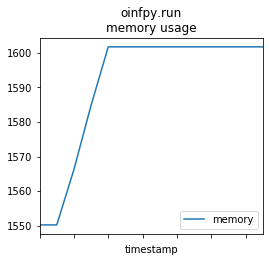

In [23]:
memprof_onx = memory_usage((oinfpy.run, ({'X': X_test32}, )), timestamps=True, interval=0.01)
mem_profile_plot(memprof_onx, "oinfpy.run");

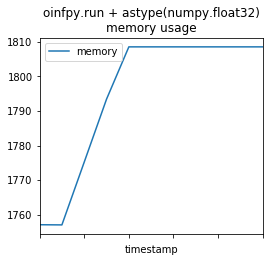

In [24]:
memprof_onx2 = memory_usage((oinfpy.run, ({'X': X_test.astype(numpy.float32, copy=False)}, )),
                           timestamps=True, interval=0.01)
mem_profile_plot(memprof_onx2, "oinfpy.run + astype(numpy.float32)");

This is not very informative.

## Memory profiling outside the notebook

More precise.

In [25]:
%%writefile mprof_clr_predict.py

import numpy
N, nfeat = 300000, 200
X = numpy.random.random((N, nfeat))
y = numpy.empty((N, 50))
for i in range(y.shape[1]):
    y[:, i] = X.sum(axis=1) + numpy.random.random(N)
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1)   

from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X_train, y_train)

from sklearn import set_config
set_config(assume_finite=True)    

from memory_profiler import profile
@profile
def clr_predict():
    clr.predict(X_test)
    
clr_predict()

Writing mprof_clr_predict.py


In [26]:
!python -m memory_profiler mprof_clr_predict.py --timestamp

Filename: mprof_clr_predict.py

Line #    Mem usage    Increment   Line Contents
    20    477.1 MiB    477.1 MiB   @profile
    21                             def clr_predict():
    22    194.1 MiB      0.0 MiB       clr.predict(X_test)




The notebook seems to increase the memory usage.

In [27]:
%%writefile mprof_onnx_run.py

import numpy
N, nfeat = 300000, 200
X = numpy.random.random((N, nfeat))
y = numpy.empty((N, 50))
for i in range(y.shape[1]):
    y[:, i] = X.sum(axis=1) + numpy.random.random(N)
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1)   

from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X_train, y_train)

from mlprodict.onnx_conv import to_onnx
from mlprodict.onnxrt import OnnxInference
clr_onnx = to_onnx(clr, X_train[:1])
oinfpy = OnnxInference(clr_onnx, runtime='python')
X_test32 = X_test.astype(numpy.float32)

from sklearn import set_config
set_config(assume_finite=True)    

from memory_profiler import profile
@profile
def oinfpy_predict():
    oinfpy.run({'X': X_test32})
    
oinfpy_predict()

Writing mprof_onnx_run.py


In [28]:
!python -m memory_profiler mprof_onnx_run.py --timestamp

Filename: mprof_onnx_run.py

Line #    Mem usage    Increment   Line Contents
    26   1310.9 MiB   1310.9 MiB   @profile
    27                             def oinfpy_predict():
    28   1311.0 MiB      0.1 MiB       oinfpy.run({'X': X_test32})




In [29]:
%%writefile mprof_onnx_run32.py

import numpy
N, nfeat = 300000, 200
X = numpy.random.random((N, nfeat))
y = numpy.empty((N, 50))
for i in range(y.shape[1]):
    y[:, i] = X.sum(axis=1) + numpy.random.random(N)
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1)   

from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X_train, y_train)

from mlprodict.onnx_conv import to_onnx
from mlprodict.onnxrt import OnnxInference
clr_onnx = to_onnx(clr, X_train[:1])
oinfpy = OnnxInference(clr_onnx, runtime='python')

from sklearn import set_config
set_config(assume_finite=True)    

from memory_profiler import profile
@profile
def oinfpy_predict32():
    oinfpy.run({'X': X_test.astype(numpy.float32)})
    
oinfpy_predict32()

Writing mprof_onnx_run32.py


In [30]:
!python -m memory_profiler mprof_onnx_run32.py --timestamp

Filename: mprof_onnx_run32.py

Line #    Mem usage    Increment   Line Contents
    25   1292.1 MiB   1292.1 MiB   @profile
    26                             def oinfpy_predict32():
    27   1292.2 MiB      0.1 MiB       oinfpy.run({'X': X_test.astype(numpy.float32)})


